<a href="https://colab.research.google.com/github/gloammer/Neural-networks/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Набор данных

https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price


In [ ]:
df = pd.read_csv(r"Tesla.csv").rename(str.lower, axis='columns')
date_days = pd.to_datetime(df.pop('date'), format='%m/%d/%Y')

my_col_name = 'close'
my_time_name = 'date'
my_plot_cols = ['open', 'high', 'close']

my_width = 24
my_shift = 1

my_conv_width = 3
wide_label_width = 24
wide_input_width = wide_label_width + (my_conv_width - 1)

my_out_steps = 24
OUT_STEPS = 24
CONV_WIDTH = 3

df.head()

,open,high,low,close,volume,adj close
0,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [ ]:
date_days.head(15)

0    2010-06-29
1    2010-06-30
2    2010-07-01
3    2010-07-02
4    2010-07-06
5    2010-07-07
6    2010-07-08
7    2010-07-09
8    2010-07-12
9    2010-07-13
10   2010-07-14
11   2010-07-15
12   2010-07-16
13   2010-07-19
14   2010-07-20
Name: date, dtype: datetime64[ns]

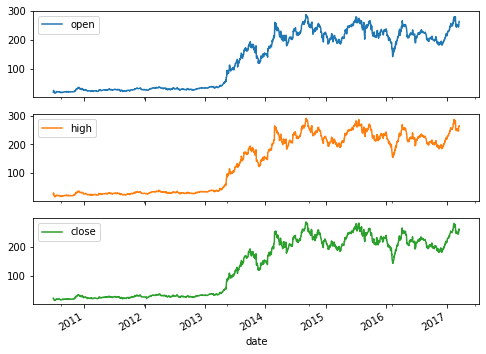

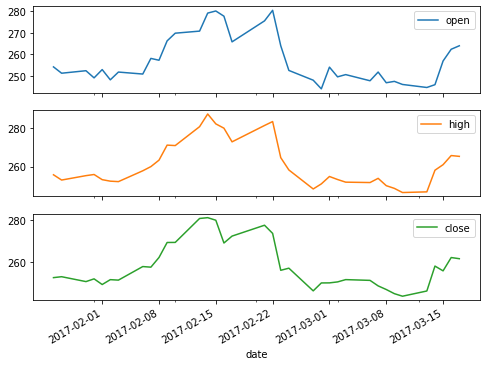

In [ ]:
plot_features = df[my_plot_cols]
plot_features.index = date_days
hello = plot_features.plot(subplots=True)

plot_features = df[my_plot_cols][-36:]
plot_features.index = date_days[-36:]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,1692.0,1.324416e+02,9.430992e+01,16.139999,3.000000e+01,1.563350e+02,2.205575e+02,2.876700e+02
high,1692.0,1.347697e+02,9.569491e+01,16.629999,3.065000e+01,1.623700e+02,2.241000e+02,2.914200e+02
low,1692.0,1.299962e+02,9.285523e+01,14.980000,2.921500e+01,1.531500e+02,2.171200e+02,2.804000e+02
close,1692.0,1.324287e+02,9.431319e+01,15.800000,2.988500e+01,1.581600e+02,2.200225e+02,2.860400e+02
volume,1692.0,4.270741e+06,4.295971e+06,118500.000000,1.194350e+06,3.180700e+06,5.662100e+06,3.716390e+07
adj close,1692.0,1.324287e+02,9.431319e+01,15.800000,2.988500e+01,1.581600e+02,2.200225e+02,2.860400e+02


## Разбиение данных

Обучение – 70%,
валидация – 20%,
проверка – 10%.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4, 'adj close': 5}

In [ ]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

val_performance = {}
test_performance = {}

val_performance2 = {}
test_performance2 = {}

multi_val_performance = {}
multi_test_performance = {}

num_features = df.shape[1]

## Нормализация данных

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Окно данных (data windowing)

Модели делают набор прогнозов на основе окна последовательных выборок из данных.

Пример:
![](images/data-windowing.png)

In [ ]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result

        return result

    def __repr__(self):
        return '\n'.join([
            f'total window size: {self.total_window_size}',
            f'input indices: {self.input_indices}',
            f'label indices: {self.label_indices}',
            f'label column name(s): {self.label_columns}'])

    def plot(self, model=None, plot_col='unnamed', plot_time='unnamed', max_subplots=3):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]

        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel(plot_time)

## Проверка класса WindowGenerator

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w1

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [47]
label column name(s): ['close']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w2

total window size: 7
input indices: [0 1 2 3 4 5]
label indices: [6]
label column name(s): ['close']

In [ ]:
example_features = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_features)

print('all shapes are: (batch, time, features)')
print(f'window shape: {example_features.shape}')
print(f'inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

all shapes are: (batch, time, features)
window shape: (3, 7, 6)
inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


In [ ]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 6, 6)
labels shape (batch, time, features): (32, 1, 1)


## Одношаговые модели

Одношаговая модель – модель, которая предсказывает значение одного признака на 1 шаг в будущем, основываясь только на текущих значениях признаков.

На входной слой модели подаются признаки (или один признак), на выходном слое модель выдаёт предсказания значений признаков (или значение одного признака) только для следующей временной метки (на 1 шаг в будущем).

![](images/model-singlestep.png)

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

total window size: 2
input indices: [0]
label indices: [1]
label column name(s): ['close']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 1, 6)
labels shape (batch, time, features): (32, 1, 1)


## Линия отсчёта (baseline)

В данной работе необходимо предсказать стоимость акции на следующий день, учитывая текущее значение всех признаков. Перед построением обучаемой модели хорошо бы иметь некоторую линию отсчёта (baseline) в качестве примера для сравнения с более сложными моделями.

Создадим модель, которая возвращает в качестве прогноза стоимость акции за текущий момент времени, иными словами модель предсказывает никаких изменений.

Такая линия отсчёта имеет смысл, так как стоимость акции меняется медленно изо дня в день, но эта модель будет работать плохо, если делать прогноз на несколько дней вперёд.

![](images/model-baseline.png)

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices[my_col_name])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['baseline'] = baseline.evaluate(single_step_window.val)
test_performance['baseline'] = baseline.evaluate(single_step_window.test)

6/6 [==============================] - 0s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0365


In [ ]:
wide_window = WindowGenerator(
    input_width=my_width, label_width=my_width, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_window

total window size: 25
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
label column name(s): ['close']

In [ ]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 6)
output shape: (32, 24, 1)


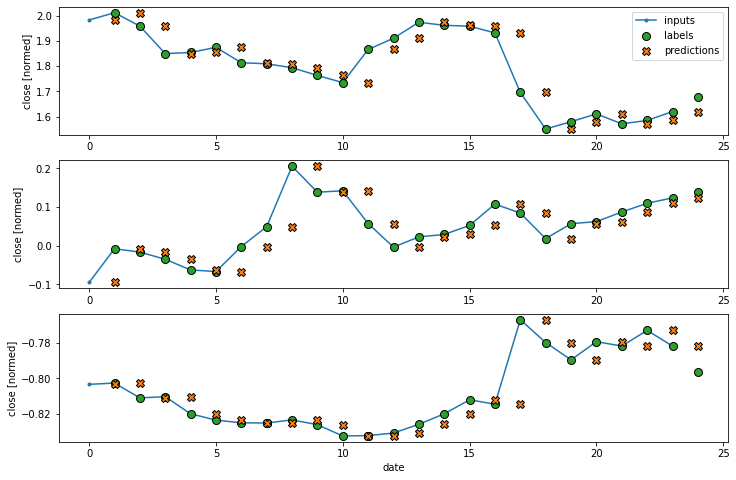

In [ ]:
wide_window.plot(baseline, plot_col=my_col_name, plot_time=my_time_name)

Синими точками (соединены синей линией) отмечены входные значения стоимости акции. Модель получает все признаки, но на данном графике представлена только стоимость акции.

Зелёные кружки показывают целевое значение прогноза. Эти точки отображаются во время прогнозирования, а не во время ввода. Именно поэтому диапазон кружков смещён на 1 шаг относительно входных данных.

Крестики – это предсказания модели для каждого выходного временного шага. Если бы модель предсказывала идеально, предсказания попадали бы прямо на зелёные кружки.

## Линейная модель

Самая простая обучаемая модель, которую возможно применить к задаче предсказания стоимости акции, это вставить линейное преобразование между входом и выходом. В этом случае значение на временном шаге зависит только от этого шага.

Схема линейной модели соответствует схеме одношаговой модели (рисунок 1). Как и в случае линии отсчёта, на каждом временном шаге предсказание не зависит от других предсказаний.

Линейное преобразование между входом и выходом. Модель ```layers.Dense``` без активации – линейная модель.

Одним из преимуществ линейных моделей является то, что они относительно просты в интерпретации. Вы можете вытащить веса слоя и увидеть вес, назначенный каждому входу:

![](images/model-singlestep.png)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('input shape:', single_step_window.example[0].shape)
print('output shape:', linear(single_step_window.example[0]).shape)

input shape: (32, 1, 6)
output shape: (32, 1, 1)


In [ ]:
def compile_and_fit(model, window, patience=2, epochs=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history

In [ ]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
test_performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
37/37 [==============================] - 1s 13ms/step - loss: 6.8433 - mean_absolute_error: 2.4488 - val_loss: 10.3800 - val_mean_absolute_error: 3.1557
Epoch 2/20
37/37 [==============================] - 0s 7ms/step - loss: 5.8415 - mean_absolute_error: 2.2617 - val_loss: 8.6099 - val_mean_absolute_error: 2.8721
Epoch 3/20
37/37 [==============================] - 0s 7ms/step - loss: 4.9599 - mean_absolute_error: 2.0825 - val_loss: 7.0998 - val_mean_absolute_error: 2.6060
Epoch 4/20
37/37 [==============================] - 0s 6ms/step - loss: 4.1876 - mean_absolute_error: 1.9121 - val_loss: 5.7816 - val_mean_absolute_error: 2.3492
Epoch 5/20
37/37 [==============================] - 0s 6ms/step - loss: 3.5126 - mean_absolute_error: 1.7496 - val_loss: 4.6612 - val_mean_absolute_error: 2.1065
Epoch 6/20
37/37 [==============================] - 0s 9ms/step - loss: 2.9291 - mean_absolute_error: 1.5952 - val_loss: 3.7086 - val_mean_absolute_error: 1.8756
Epoch 7/20
37/37 [========

In [ ]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 6)
output shape: (32, 24, 1)


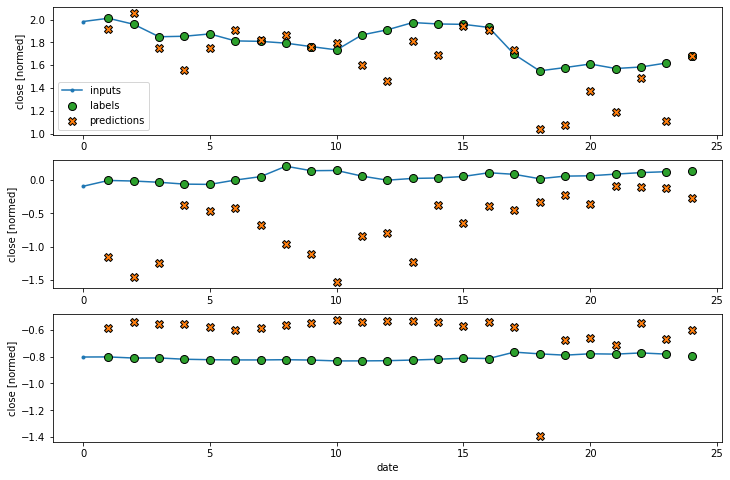

In [ ]:
wide_window.plot(linear, plot_col=my_col_name, plot_time=my_time_name)

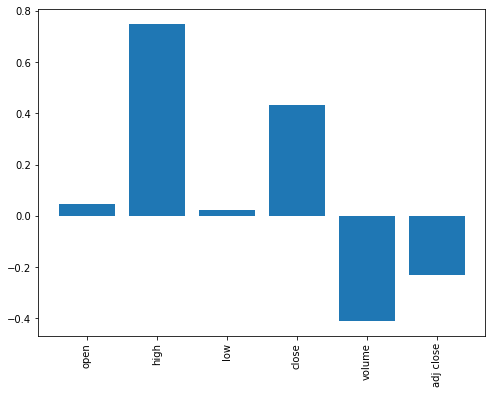

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Полносвязанная модель (dense)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
%%time
history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
test_performance['dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
37/37 [==============================] - 2s 15ms/step - loss: 0.1529 - mean_absolute_error: 0.2520 - val_loss: 0.0091 - val_mean_absolute_error: 0.0746
Epoch 2/20
37/37 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_absolute_error: 0.0419 - val_loss: 0.0058 - val_mean_absolute_error: 0.0564
Epoch 3/20
37/37 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0291 - val_loss: 0.0059 - val_mean_absolute_error: 0.0573
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0284 - val_loss: 0.0056 - val_mean_absolute_error: 0.0552
Epoch 5/20
37/37 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0281 - val_loss: 0.0057 - val_mean_absolute_error: 0.0569
Epoch 6/20
37/37 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0283 - val_loss: 0.0056 - val_mean_absolute_error: 0.0560
Epoch 7/20
37/37 [=======

## Многошаговая полносвязанная модель

Модель с одним временным шагом не имеет контекста для текущих значений своих входных данных. Она не может видеть, как входные функции меняются с течением времени. Для решения этой проблемы модели необходим доступ к нескольким временным шагам при составлении прогнозов.

Линия отсчёта и линейная модель обрабатывали каждый временной шаг независимо. Многошаговая модель будет принимать несколько временных шагов в качестве входных данных для получения одного вывода.

![](images/model-multistep-dense.png)

In [ ]:
conv_window = WindowGenerator(
    input_width=my_conv_width, label_width=1, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
conv_window

total window size: 4
input indices: [0 1 2]
label indices: [3]
label column name(s): ['close']

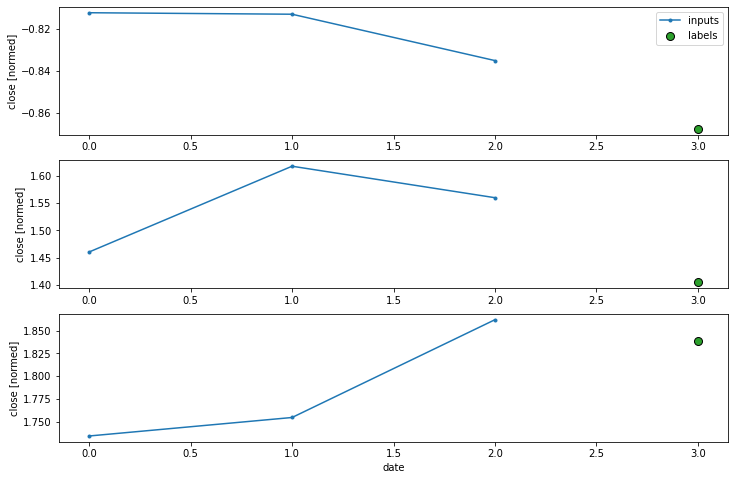

In [ ]:
conv_window.plot(plot_col=my_col_name, plot_time=my_time_name)

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # add back the time dimension
    # shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', multi_step_dense(conv_window.example[0]).shape)

input shape: (32, 3, 6)
output shape: (32, 1, 1)


In [ ]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['multi_step'] = multi_step_dense.evaluate(conv_window.val)
test_performance['multi_step'] = multi_step_dense.evaluate(conv_window.test)

6/6 [==============================] - 0s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0689
CPU times: user 3.72 s, sys: 459 ms, total: 4.18 s
Wall time: 4.13 s


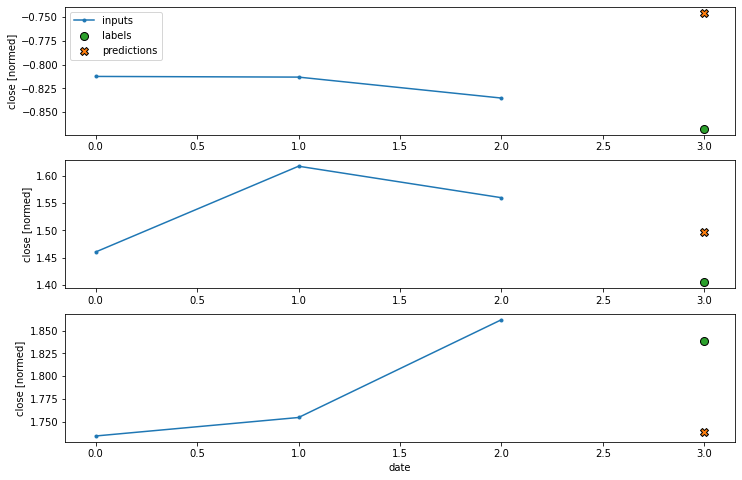

In [ ]:
conv_window.plot(multi_step_dense, plot_col=my_col_name, plot_time=my_time_name)

Основным недостатком этого подхода является то, что полученная модель может быть выполнена только на входных окнах именно такой формы.

In [ ]:
print('input shape:', wide_window.example[0].shape)
try:
    print('output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

input shape: (32, 24, 6)

ValueError:Exception encountered when calling layer "sequential_26" (type Sequential).

Input 0 of layer "dense_48" is incompatible with the layer: expected axis -1 of input shape to have value 18, but received input with shape (32, 144)

Call arguments received by layer "sequential_26" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 6), dtype=float32)
  • training=None
  • mask=None


## Свёрточная нейронная сеть

Создадим свёрточную нейронную сеть. Эта нейросеть состоит из двух слоёв:
– свёрточный слой с размером фильтра 32 и размером ядра 3;
– слой из 32-ух полносвязанных нейрона.

Разница между этой моделью и многошаговой полносвязанной моделью заключается в том, что свёрточная модель может выполняться на входах любой длины. Свёрточный слой наносится на скользящее окно входных данных. На рисунке 6 представлена схема свёрточной нейронной сети.

![](images/model-convolution.png)

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(my_conv_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', conv_model(conv_window.example[0]).shape)

input shape: (32, 3, 6)
output shape: (32, 1, 1)


In [ ]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['conv'] = conv_model.evaluate(conv_window.val)
test_performance['conv'] = conv_model.evaluate(conv_window.test)

6/6 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_error: 0.0631
CPU times: user 8.35 s, sys: 1.17 s, total: 9.52 s
Wall time: 10.6 s


In [ ]:
print("wide window:")
print('input shape:', wide_window.example[0].shape)
print('labels shape:', wide_window.example[1].shape)
print('output shape:', conv_model(wide_window.example[0]).shape)

wide window:
input shape: (32, 24, 6)
labels shape: (32, 24, 1)
output shape: (32, 22, 1)


In [ ]:
wide_conv_window = WindowGenerator(
    input_width=wide_input_width,
    label_width=wide_label_width,
    shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_conv_window

total window size: 27
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
label column name(s): ['close']

In [ ]:
print("wide conv window:")
print('input shape:', wide_conv_window.example[0].shape)
print('labels shape:', wide_conv_window.example[1].shape)
print('output shape:', conv_model(wide_conv_window.example[0]).shape)

wide conv window:
input shape: (32, 26, 6)
labels shape: (32, 24, 1)
output shape: (32, 24, 1)


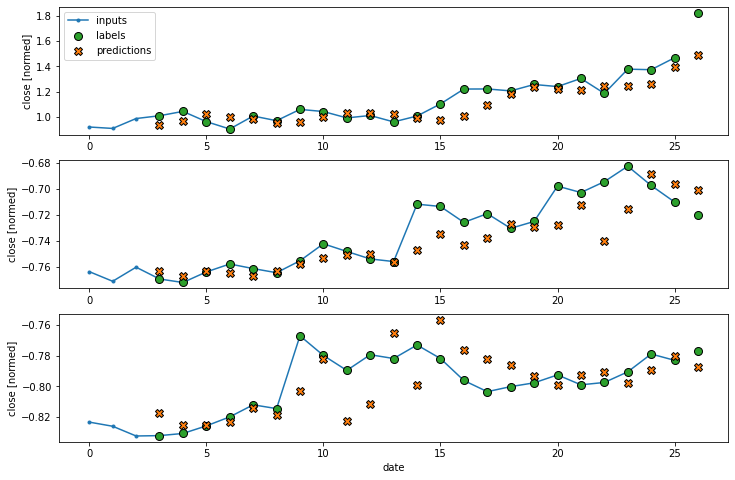

In [ ]:
wide_conv_window.plot(conv_model, plot_col=my_col_name, plot_time=my_time_name)

## Рекуррентная нейронная сеть

Рекуррентные нейронные сети (РНС) – это класс нейронных сетей, который эффективен для моделирования данных последовательности, таких как временные ряды или естественный язык.

РНС использует цикл for для перебора временных шагов последовательности, сохраняя при этом внутреннее состояние, которое кодирует информацию о временных шагах, которые она видела.

Важным аргументом конструктора для всех слоёв Keras RNN является аргумент ```return_sequences```. Этот параметр позволяет настроить слой одним из двух способов.

Если значение по умолчанию равно ```False```, слой возвращает только выходные данные конечного временного шага, давая модели время для прогрева её внутреннего состояния перед выполнением одного прогноза:

![](images/model-recurrent-1.png)

Если ```True```, слой возвращает выходные данные для каждого входа. Это полезно для:
– использования нескольких рекуррентных слоёв;
– обучение модели на нескольких временных шагах одновременно.

![](images/model-recurrent-2.png)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', lstm_model(wide_window.example[0]).shape)

input shape: (32, 24, 6)
output shape: (32, 24, 1)


In [ ]:
%%time
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
test_performance['lstm'] = lstm_model.evaluate(wide_window.test)

5/5 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_error: 0.0579
CPU times: user 24.5 s, sys: 1.66 s, total: 26.2 s
Wall time: 27 s


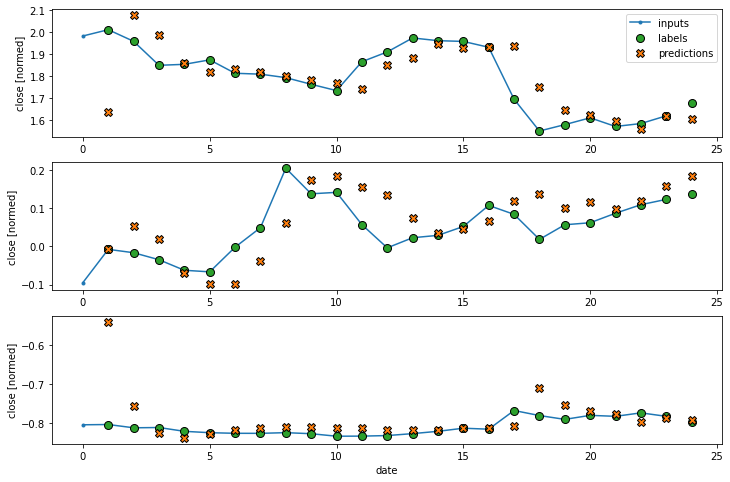

In [ ]:
wide_window.plot(lstm_model, plot_col=my_col_name, plot_time=my_time_name)

## Сравнение моделей

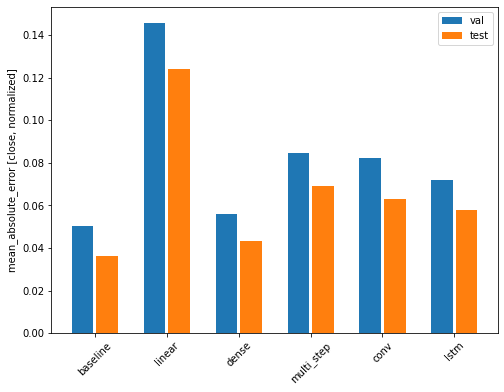

In [ ]:
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.ylabel(f'mean_absolute_error [{my_col_name}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance.keys(), rotation=45)
_ = plt.legend()

In [ ]:
for name, value in test_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

baseline    : 0.0365
linear      : 0.1242
dense       : 0.0434
multi_step  : 0.0689
conv        : 0.0631
lstm        : 0.0579


## Модели с несколькими выходами (multi-output models)

Все модели до сих пор предсказывали одну выходной признак для одного временного шага.

Все рассмотренные ранее модели могут быть преобразованы для прогнозирования нескольких признаков, просто изменив количество единиц измерения в выходном слое и настроив обучающие окна для включения всех признаков в метки.

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels
    # if you don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 24, 6)
labels shape (batch, time, features): (32, 24, 6)


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance2['baseline'] = baseline.evaluate(wide_window.val)
test_performance2['baseline'] = baseline.evaluate(wide_window.test)

5/5 [==============================] - 0s 3ms/step - loss: 0.0332 - mean_absolute_error: 0.0789


In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance2['dense'] = dense.evaluate(single_step_window.val)
test_performance2['dense'] = dense.evaluate(single_step_window.test)

6/6 [==============================] - 0s 3ms/step - loss: 0.0309 - mean_absolute_error: 0.0890


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance2['lstm'] = lstm_model.evaluate( wide_window.val)
test_performance2['lstm'] = lstm_model.evaluate( wide_window.test)

5/5 [==============================] - 0s 5ms/step - loss: 0.0378 - mean_absolute_error: 0.1099
CPU times: user 23.6 s, sys: 1.68 s, total: 25.3 s
Wall time: 25 s


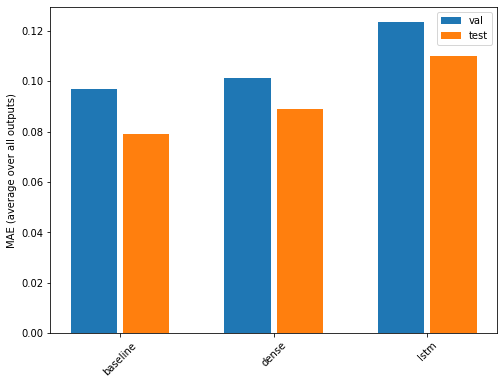

In [ ]:
x = np.arange(len(test_performance2))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance2.values()]
test_mae = [v[metric_index] for v in test_performance2.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance2.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in test_performance2.items():
    print(f'{name:15s}: {value[1]:0.4f}')

baseline       : 0.0789
dense          : 0.0890
lstm           : 0.1099


## Многошаговые модели

При многошаговом прогнозировании модель должна научиться предсказывать диапазон будущих значений. Таким образом, в отличие от одношаговой модели, где предсказывается только одна будущая точка, многошаговая модель предсказывает последовательность будущих значений.

Существуют два подхода многошагового предсказания:
– разовые прогнозы – весь временной ряд предсказывается сразу;
– авторегрессионные прогнозы – модель предсказывает один шаг, а её выходные данные возвращаются в качестве входных данных.

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
label column name(s): None

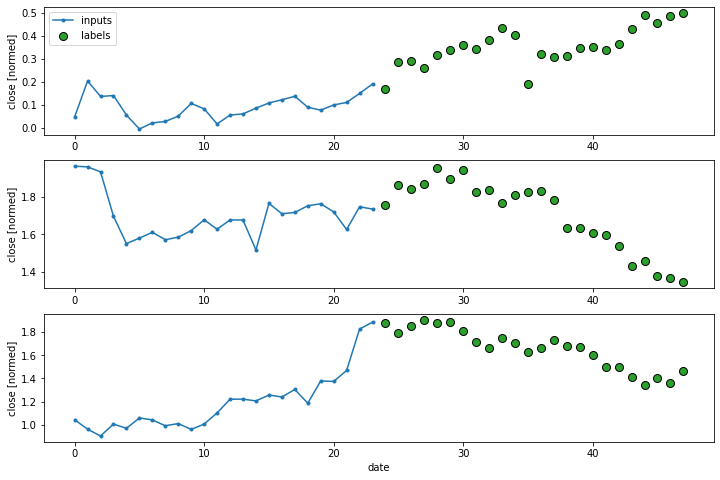

In [ ]:
multi_window = WindowGenerator(input_width=24, label_width=my_out_steps, shift=my_out_steps,
                               train_df=train_df, val_df=val_df, test_df=test_df)
multi_window.plot(plot_col=my_col_name, plot_time=my_time_name)
multi_window

## Линия отсчёта (baseline)

Простая линия отсчёта для этой задачи состоит в том, чтобы повторить последний шаг времени ввода для требуемого количества временных шагов вывода.

![](images/model-multistep-baseline-1.png)

In [ ]:
class MultistepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [ ]:
last_baseline = MultistepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['last'] = last_baseline.evaluate(multi_window.val)
multi_test_performance['last'] = last_baseline.evaluate(multi_window.test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0816 - mean_absolute_error: 0.1898


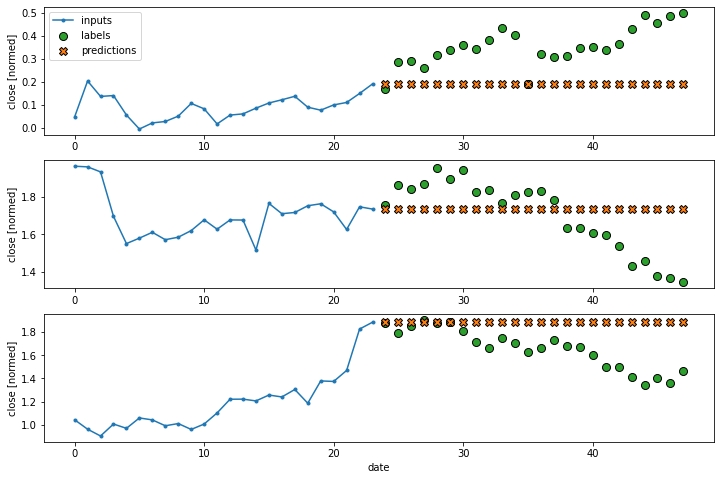

In [ ]:
multi_window.plot(last_baseline, plot_col=my_col_name, plot_time=my_time_name)

Поскольку задача многошаговой модели заключается в том, чтобы предсказать n шагов, учитывая n последних шагов, существует другой подход определения линии отсчёта, он состоит в том, чтобы повторить предыдущие n шагов, предполагая, что следующие будут такими же.

![](images/model-multistep-baseline-2.png)

In [ ]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [ ]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_test_performance['repeat'] = repeat_baseline.evaluate(multi_window.test)

4/4 [==============================] - 0s 4ms/step - loss: 0.1206 - mean_absolute_error: 0.2641


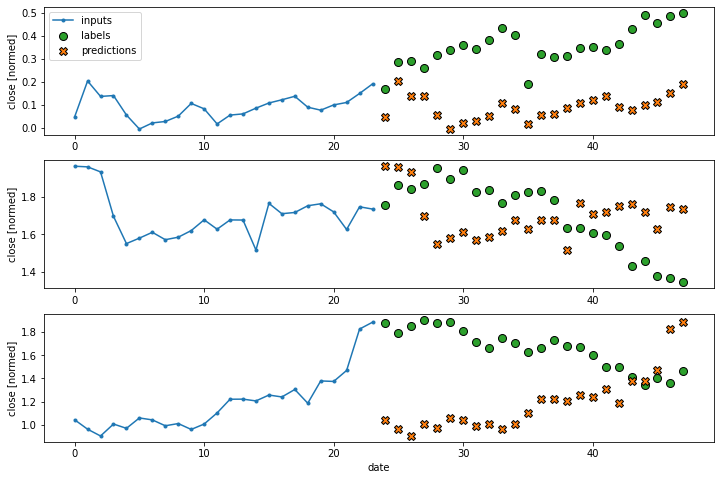

In [ ]:
multi_window.plot(repeat_baseline, plot_col=my_col_name, plot_time=my_time_name)

## Предсказание всей последовательности за один шаг

## Линейная модель

Простая линейная модель, основанная на последнем временном шаге ввода, работает лучше, чем линия отсчёта (baseline). Модель должна предсказывать n временных шагов с одного входного временного шага с линейной проекцией. Он может захватить только низкоразмерный срез поведения, вероятно, основанный в основном на времени суток и времени года.

![](images/model-multistep-linear.png)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
%%time
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['linear'] = multi_linear_model.evaluate(multi_window.val)
multi_test_performance['linear'] = multi_linear_model.evaluate(multi_window.test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0968 - mean_absolute_error: 0.2181
CPU times: user 8.21 s, sys: 1.25 s, total: 9.47 s
Wall time: 8.47 s


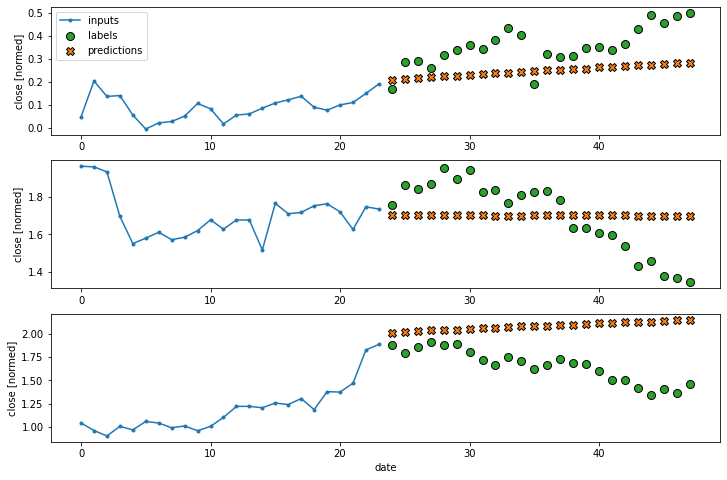

In [ ]:
multi_window.plot(multi_linear_model, plot_col=my_col_name, plot_time=my_time_name)

## Полносвязанная модель (dense)

Добавление плотного слоя между входом и выходом даёт линейной модели больше мощности, но модель по-прежнему основана только на одном временном шаге ввода.

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
%%time
history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['dense'] = multi_dense_model.evaluate(multi_window.val)
multi_test_performance['dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.1156 - mean_absolute_error: 0.2500
CPU times: user 6.06 s, sys: 679 ms, total: 6.74 s
Wall time: 7.58 s


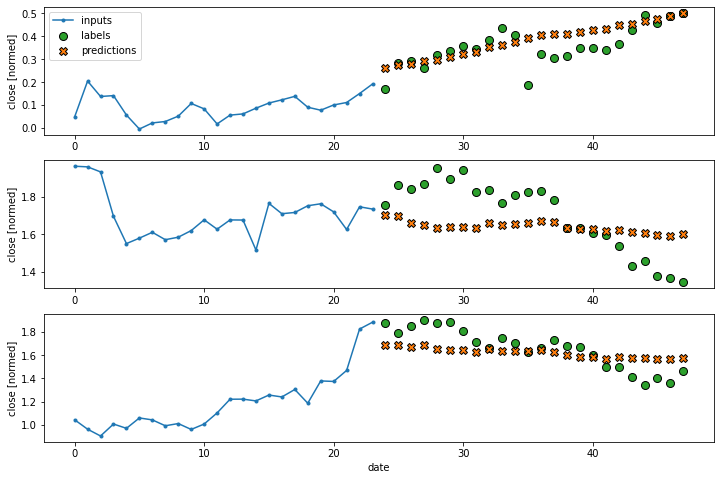

In [ ]:
multi_window.plot(multi_dense_model, plot_col=my_col_name, plot_time=my_time_name)

## Cвёрточная нейронная сеть

Свёрточная модель делает прогнозы на основе последовательности значений определённой ширины, что может привести к лучшей производительности, чем плотная модель, поскольку модель может видеть, как значение признака меняется с течением времени.

![](images/model-multistep-convolution.png)

In [ ]:
multi_conv_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
%%time
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['conv'] = multi_conv_model.evaluate(multi_window.test)

4/4 [==============================] - 0s 5ms/step - loss: 0.0882 - mean_absolute_error: 0.2168
CPU times: user 4.16 s, sys: 474 ms, total: 4.64 s
Wall time: 4.76 s


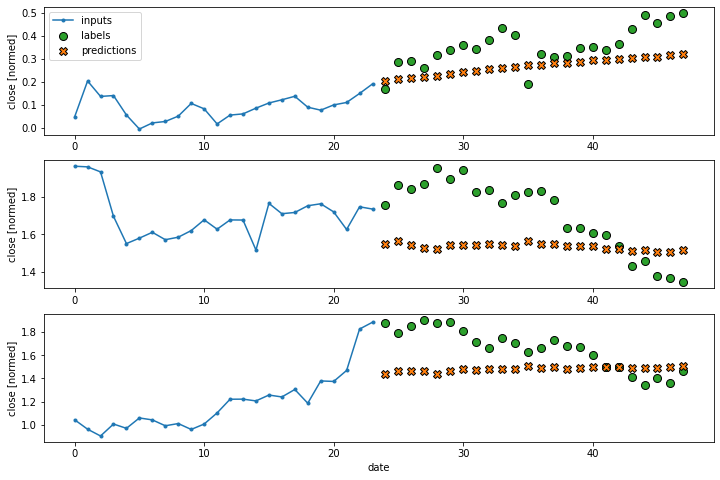

In [ ]:
multi_window.plot(multi_conv_model, plot_col=my_col_name, plot_time=my_time_name)

## Рекуррентная модель

Рекуррентная модель использует длинную последовательность входных данных. Модель накапливает внутреннее состояние в течение n временных шагов, прежде чем сделать один прогноз на следующие n шага.

![](images/model-multistep-recurrent.png)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
%%time
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['lstm'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['lstm'] = multi_lstm_model.evaluate(multi_window.test)

4/4 [==============================] - 0s 7ms/step - loss: 0.0770 - mean_absolute_error: 0.2233
CPU times: user 17.6 s, sys: 1.17 s, total: 18.8 s
Wall time: 19.4 s


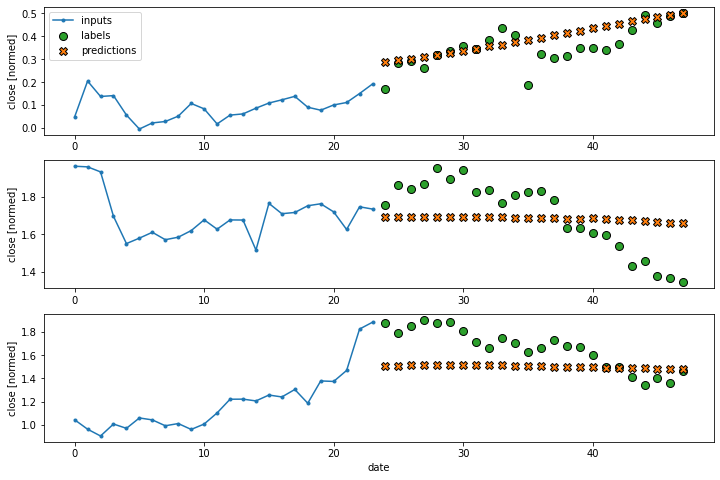

In [ ]:
multi_window.plot(multi_lstm_model, plot_col=my_col_name, plot_time=my_time_name)

## Авторегрессионная модель

В авторегрессионной модели выходные данные могут быть возвращены в саму себя на каждом шаге, и прогнозы могут быть сделаны с учётом предыдущих временных шагов.

![](images/model-multistep-autoregressive.png)

## Рекуррентная модель

In [ ]:
class Feedback(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                      training=training)

            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [ ]:
feedback_model = Feedback(units=32, out_steps=OUT_STEPS)

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 6])

In [ ]:
print('output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

output shape (batch, time, features):  (32, 24, 6)


In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()
multi_val_performance['autoregr'] = feedback_model.evaluate(multi_window.val)
multi_test_performance['autoregr'] = feedback_model.evaluate(multi_window.test)

4/4 [==============================] - 0s 9ms/step - loss: 0.1411 - mean_absolute_error: 0.3326


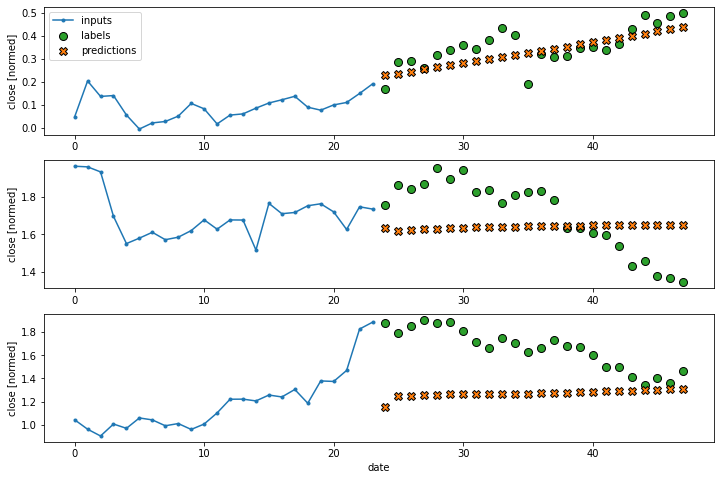

In [ ]:
multi_window.plot(feedback_model, plot_col=my_col_name, plot_time=my_time_name)

## Сравнение многошаговых моделей

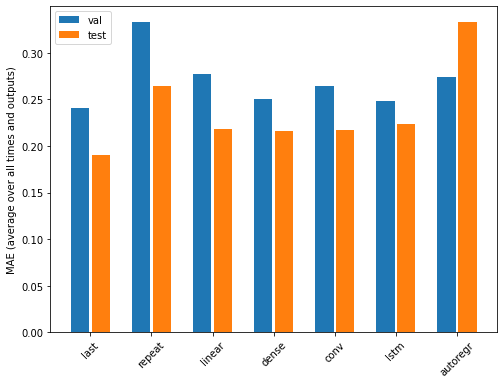

In [ ]:
x = np.arange(len(multi_test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()